#IMPORT LIBRARY

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Deskripsi Data

1.1 deskripsi data

Data terdiri 3 kolom:

title  : nama sepeda

rating : rating produk

harga  : harga sepeda

Penjualan : Total penjualan produk


## sumber data

1.2 sumber data

data di ambil dari web rodalink yang merupakan dealer resmi untuk merek sepeda Polygon, Marin, Tern dan Wimcycle.


#SCREPING DATA

In [2]:
base_url = "https://www.rodalink.com/id/catalogsearch/result/index/?p={}&q=sepeda"
total_pages = 4  # Replace with the number of pages to scrape

sepeda = []  # Initialize list to store scraped data

for page in range(1, total_pages + 1):
    url = base_url.format(page)
    print(f"Scraping page {page}(Done): {url}")

    # Get Request to Website
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Scraping product-item-info divs
        card_desc = soup.find_all('div', class_='product-item-info')

        # Scraping for "Title", "Price", and "Rating"
        for row in card_desc:
            # Title
            Title = row.find('a', class_='product-item-link')
            Title = Title.text.strip() if Title else np.nan

            # Price
            price = row.find('span', class_='price')
            price = price.text.strip() if price else np.nan

            # Rating
            rating_elements = row.find('span', class_='rating-value')
            rating = rating_elements.text.strip() if rating_elements else np.nan

            # Hasil penjualan
            hasil_penjualan= row.find('span', class_='total-sold-value')
            hasil_penjualan = hasil_penjualan.text.strip() if hasil_penjualan else np.nan

            sepeda.append({'Title': Title, 'Rating': rating, 'Price': price, 'Penjualan': hasil_penjualan})

    else:
        print(f"Error: Failed to fetch data from {url}")


Scraping page 1(Done): https://www.rodalink.com/id/catalogsearch/result/index/?p=1&q=sepeda
Scraping page 2(Done): https://www.rodalink.com/id/catalogsearch/result/index/?p=2&q=sepeda
Scraping page 3(Done): https://www.rodalink.com/id/catalogsearch/result/index/?p=3&q=sepeda
Scraping page 4(Done): https://www.rodalink.com/id/catalogsearch/result/index/?p=4&q=sepeda


In [3]:
df = pd.DataFrame(sepeda)
df

,Title,Rating,Price,Penjualan
0,Polygon Sepeda Kota Oosten 24,NaN,Rp 3.900.000,NaN
1,Polygon Sepeda Kota Claire 24,5,Rp 3.500.000,2rb+ Terjual
2,Polygon Sepeda Kota Lovina 24,5,Rp 2.050.000,2rb+ Terjual
3,Polygon Sepeda Kota Lovina 20,5,Rp 1.950.000,3rb+ Terjual
4,Polygon Sepeda Kota Coastal 20,4.9,Rp 1.775.000,2rb+ Terjual
...,...,...,...,...
95,Wimcycle Sepeda BMX Dragster Goal 20,5,Rp 1.650.000,198 Terjual
96,Polygon Sepeda Gravel Bend R5,5,Rp 19.200.000,832 Terjual
97,Polygon Sepeda MTB Dual Suspensi Siskiu N9,5,Rp 40.500.000,487 Terjual
98,Marin Sepeda Gravel Lombard 2,NaN,Rp 19.000.000,99 Terjual


#DATA WRANGLING

## info type data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      100 non-null    object
 1   Rating     65 non-null     object
 2   Price      96 non-null     object
 3   Penjualan  94 non-null     object
dtypes: object(4)
memory usage: 3.2+ KB


### rubah type data

#change of type data

In [5]:
# Fungsi untuk mengonversi 'Price' dari format 'Rp 3.500.000' ke 3500000
def convert_price(price):
    if isinstance(price, str): # Check if the price is a string
        price = price.replace('Rp ', '')  # Hapus 'Rp '
        price = price.replace('.', '')    # Hapus titik
        return int(price)
    else:
        return price # Return the original value if not a string

# Fungsi untuk mengonversi 'Penjualan' dari format '2rb+ Terjual' ke angka
def convert_sales(sales):
    if isinstance(sales, str): # Check if sales is a string
        sales = sales.replace(' Terjual', '')  # Hapus ' Terjual'
        sales = sales.replace('rb+', '001')    # Ganti 'rb+' dengan '000'
        return int(sales)
    else:
        return sales # Return the original value if not a string



# Mengonversi kolom 'Price' dan 'Penjualan'
df['Price'] = df['Price'].apply(convert_price)
df['Penjualan'] = df['Penjualan'].apply(convert_sales)

# Mengonversi kolom 'Rating' ke float jika belum numerik
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

## buat kolom baru (brand)

In [6]:
df['Brand'] = df['Title'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else None)

In [34]:
unique_values = df['Brand'].unique()
print("Nilai unik di kolom 'Brand':")
print(unique_values)


Nilai unik di kolom 'Brand':
['Polygon' 'Wimcycle' 'Sepeda' 'Tern' 'Marin']


In [35]:
sepeda_data = df[df['Brand'] == 'Sepeda']

sepeda_data

,Title,Rating,Price,Penjualan,Brand
25,Sepeda Gunung Polygon Xtrada 5,4.9,6400000,5001,Sepeda


In [37]:
# Mengubah nilai Brand menjadi 'Polygon' pada baris tertentu
df.loc[(df['Title'] == 'Sepeda Gunung Polygon Xtrada 5') & (df['Brand'] == 'Sepeda'), 'Brand'] = 'Polygon'

## missing value


In [7]:
df.isna().sum()

,0
Title,0
Rating,35
Price,4
Penjualan,6
Brand,4


In [8]:
# Mengisi missing values
df.fillna(df.mean(numeric_only=True), inplace=True)  # Mengisi kolom numerik dengan mean
df.fillna(df.mode().iloc[0], inplace=True)  # Mengisi kolom non-numerik dengan modus

In [9]:
df.isna().sum()

,0
Title,0
Rating,0
Price,0
Penjualan,0
Brand,0


In [21]:
df.head()

,Title,Rating,Price,Penjualan,Brand
0,Polygon Sepeda Kota Oosten 24,4.944615,3900000.0,1049,Polygon
1,Polygon Sepeda Kota Claire 24,5.000000,3500000.0,2001,Polygon
2,Polygon Sepeda Kota Lovina 24,5.000000,2050000.0,2001,Polygon
3,Polygon Sepeda Kota Lovina 20,5.000000,1950000.0,3001,Polygon
4,Polygon Sepeda Kota Coastal 20,4.900000,1775000.0,2001,Polygon


rubah float  penjualan ke int

In [22]:
df['Penjualan'] = df['Penjualan'].astype(int)

In [24]:
df['Price'] = df['Price'].astype(int)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      100 non-null    object 
 1   Rating     100 non-null    float64
 2   Price      100 non-null    int64  
 3   Penjualan  100 non-null    int64  
 4   Brand      100 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ KB


#EDA

In [26]:
df

,Title,Rating,Price,Penjualan,Brand
0,Polygon Sepeda Kota Oosten 24,4.944615,3900000,1049,Polygon
1,Polygon Sepeda Kota Claire 24,5.000000,3500000,2001,Polygon
2,Polygon Sepeda Kota Lovina 24,5.000000,2050000,2001,Polygon
3,Polygon Sepeda Kota Lovina 20,5.000000,1950000,3001,Polygon
4,Polygon Sepeda Kota Coastal 20,4.900000,1775000,2001,Polygon
...,...,...,...,...,...
95,Wimcycle Sepeda BMX Dragster Goal 20,5.000000,1650000,198,Wimcycle
96,Polygon Sepeda Gravel Bend R5,5.000000,19200000,832,Polygon
97,Polygon Sepeda MTB Dual Suspensi Siskiu N9,5.000000,40500000,487,Polygon
98,Marin Sepeda Gravel Lombard 2,4.944615,19000000,99,Marin


## statistik

In [27]:
# Menampilkan statistik deskriptif
print("Statistik Deskriptif:")
print(df.describe())


Statistik Deskriptif:
           Rating         Price    Penjualan
count  100.000000  1.000000e+02   100.000000
mean     4.944615  1.273246e+07  1049.650000
std      0.123117  1.682064e+07  1362.294576
min      4.000000  1.165000e+06     2.000000
25%      4.944615  2.548750e+06    93.500000
50%      5.000000  7.675000e+06   736.500000
75%      5.000000  1.293750e+07  1049.000000
max      5.000000  9.300000e+07  7001.000000


## visualisasi

### rata rata harga brand

In [39]:
# Brand dengan harga tertinggi secara keseluruhan
brand_harga_tertinggi = df.loc[df['Price'].idxmax()]
print("Brand dengan harga tertinggi secara keseluruhan:")
print(brand_harga_tertinggi[['Brand', 'Price']])

# Jika ingin melihat harga tertinggi per brand
harga_tertinggi_per_brand = df.groupby('Brand')['Price'].max().sort_values(ascending=False)
print("\nHarga tertinggi per brand:")
print(harga_tertinggi_per_brand)

Brand dengan harga tertinggi secara keseluruhan:
Brand     Polygon
Price    93000000
Name: 67, dtype: object

Harga tertinggi per brand:
Brand
Polygon     93000000
Marin       41300000
Tern        11000000
Wimcycle     3250000
Name: Price, dtype: int64


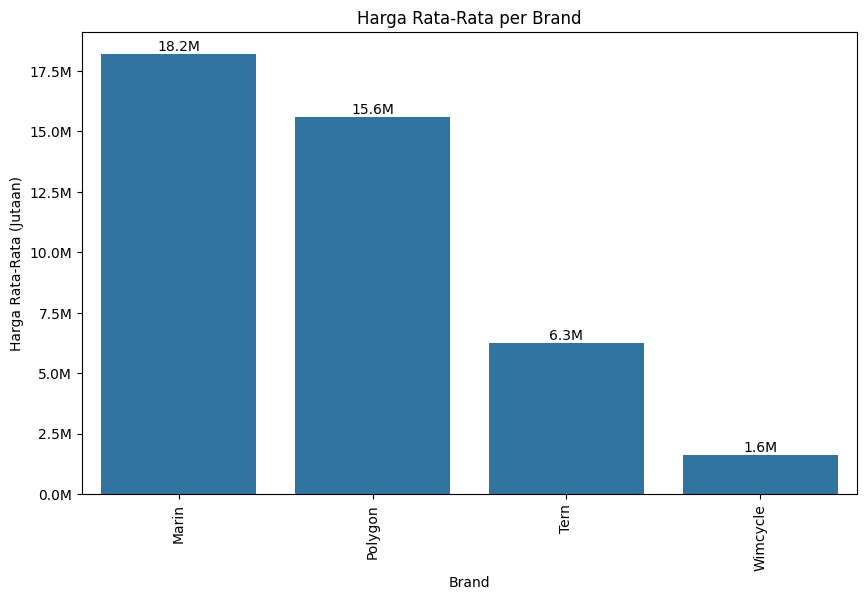

In [43]:
from matplotlib.ticker import FuncFormatter
avg_price_per_brand = df.groupby('Brand')['Price'].mean().sort_values(ascending=False)

# Fungsi untuk memformat angka dalam jutaan
def millions(x, pos):
    return f'{x * 1e-6:.1f}M'

# Visualisasi dengan pengaturan sumbu y dalam jutaan
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=avg_price_per_brand.index, y=avg_price_per_brand.values)
plt.title('Harga Rata-Rata per Brand')
plt.xlabel('Brand')
plt.ylabel('Harga Rata-Rata (Jutaan)')
plt.xticks(rotation=90)

# Terapkan formatter untuk sumbu y
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

# Menambahkan label angka di setiap bar
for index, value in enumerate(avg_price_per_brand.values):
    plt.text(index, value, f'{value * 1e-6:.1f}M', ha='center', va='bottom')

plt.show()

### top 5 sepeda terlaris

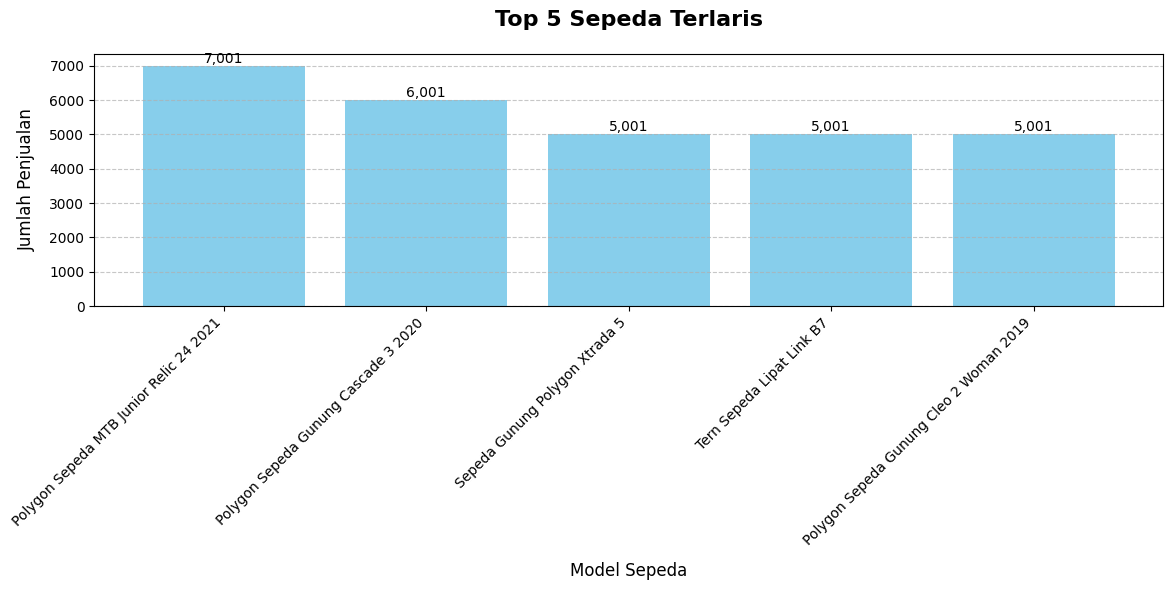

In [46]:
# Mengambil top 5 sepeda terlaris berdasarkan Penjualan
top_5_sepeda = df.nlargest(5, 'Penjualan')

# Membuat plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_5_sepeda['Title'], top_5_sepeda['Penjualan'], color='skyblue')

# Menambahkan label di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

# Mempercantik tampilan
plt.title('Top 5 Sepeda Terlaris', pad=20, size=16, weight='bold')
plt.xlabel('Model Sepeda', labelpad=10, size=12)
plt.ylabel('Jumlah Penjualan', labelpad=10, size=12)
plt.xticks(rotation=45, ha='right', size=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mengatur layout agar tidak terpotong
plt.tight_layout()

# Menampilkan plot
plt.show()

# KESIMPULAN

Berdasarkan hasil visualisasi yang kami tampilkan, berikut beberapa meaningful insight yang bisa diperoleh dari setiap grafik:

1. Perbandingan rata-rata Harga antar Brand:

- Marin memiliki harga rata-rata tertinggi sekitar 18.2juta rupiah

- Polygon berada di posisi kedua dengan harga rata-rata 15.6juta rupiah

- Tern di posisi ketiga dengan 6.3juta rupiah

- Wimcycle memiliki harga rata-rata terendah yaitu 1.6juta rupiah

Strategi Positioning:


Terdapat perbedaan positioning yang jelas antar brand:

- Marin memposisikan diri sebagai brand premium

- Polygon bersaing di segmen premium tapi dengan harga sedikit lebih terjangkau dari Marin

- Tern mengisi ceruk pasar menengah

- Wimcycle jelas menarget pasar ekonomis

2. Top 5 sepeda terlaris:

- Polygon Sepeda MTB Junior Rodic 24 2021 adalah yang terlaris dengan 7,001 unit terjual
- Polygon Sepeda Gunung Cascade 3 2020 di posisi kedua dengan 6,001 unit

- Tiga model lainnya (Polygon Xtrada 5, Tern Lipat Link B7, dan Polygon Cleo 2) memiliki penjualan yang sama yaitu 5,001 unit

In [18]:
df.to_csv('sepeda.csv',index=False)
#